## Accessing MODIS temperature data with the Planetary Computer STAC API

The planetary computer hosts three temperature-related MODIS 6.1 products:

- Land Surface Temperature/Emissivity Daily (11A1)
- Land Surface Temperature/Emissivity 8-Day (11A2)
- Land Surface Temperature/3-Band Emissivity 8-Day (21A2)

For more information about the products themselves, check out the User Guides at the [bottom of this document](#user-guides).

### Environment setup

This notebook works with or without an API key, but you will be given more permissive access to the data with an API key.
The Planetary Computer Hub is pre-configured to use your API key.

In [1]:
import odc.stac
import planetary_computer
import pystac_client
import rich.table

### Data access

The datasets hosted by the Planetary Computer are available from [Azure Blob Storage](https://docs.microsoft.com/en-us/azure/storage/blobs/). We'll use [pystac-client](https://pystac-client.readthedocs.io/) to search the Planetary Computer's [STAC API](https://planetarycomputer.microsoft.com/api/stac/v1/docs) for the subset of the data that we care about, and then we'll load the data directly from Azure Blob Storage. We'll specify a `modifier` so that we can access the data stored in the Planetary Computer's private Blob Storage Containers. See [Reading from the STAC API](https://planetarycomputer.microsoft.com/docs/quickstarts/reading-stac/) and [Using tokens for data access](https://planetarycomputer.microsoft.com/docs/concepts/sas/) for more.

In [2]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

### Query for available data

MODIS is a global dataset with a variety of products available within each larger category (vegetation, snow, fire, temperature, and reflectance). The [MODIS group](https://planetarycomputer.microsoft.com/dataset/group/modis) contains a complete listing of available collections. Each collection's format follows`modis-{product}-061`, where `product` is the MODIS product id. The `-061` suffix indicates that all of the MODIS collections are part of the [MODIS 6.1 update](https://atmosphere-imager.gsfc.nasa.gov/documentation/collection-61).


Let's access Land Surface Temperature/Emissivity Daily (11A1) data over Boise, Idaho in 2021. We'll get four images for the midseasonal months: March, June, September, and December. 

In [3]:
# Boise, Idaho
latitude = 43.6
longitude = -116.2
buffer = 1
bbox = [longitude - buffer, latitude - buffer, longitude + buffer, latitude + buffer]
year = "2021"
months = {
    "March": "03",
    "June": "06",
    "September": "09",
    "December": "12",
}
items = dict()

# Fetch the collection of interest and print availabe items
for name, number in months.items():
    datetime = f"{year}-{number}"
    search = catalog.search(
        collections=["modis-11A1-061"],
        bbox=bbox,
        datetime=datetime,
    )
    items[name] = search.get_all_items()[0]

print(items)

{'March': <Item id=MYD11A1.A2021090.h09v04.061.2021092201848>, 'June': <Item id=MYD11A1.A2021181.h09v04.061.2021183191149>, 'September': <Item id=MYD11A1.A2021273.h09v04.061.2021277222441>, 'December': <Item id=MYD11A1.A2021365.h09v04.061.2022004014918>}


### Available assets

Each item has several available assets, including the original HDF file and a Cloud-optimized GeoTIFF of each subdataset.

In [4]:
t = rich.table.Table("Key", "Title")
for key, asset in items["March"].assets.items():
    t.add_row(key, asset.title)
t

┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Key              ┃ Title                                                               ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ hdf              │ Source data containing all bands                                    │
│ QC_Day           │ Quality control for daytime LST and emissivity                      │
│ Emis_31          │ Band 31 emissivity                                                  │
│ Emis_32          │ Band 32 emissivity                                                  │
│ QC_Night         │ Quality control for nighttime LST and emissivity                    │
│ metadata         │ Federal Geographic Data Committee (FGDC) Metadata                   │
│ LST_Day_1km      │ Daily daytime 1km grid Land-surface Temperature                     │
│ Clear_day_cov    │ Day clear-sky coverage                                              │
│ Day_view_angl    │ View zenith angle of daytime Landsurface Temperature                │
│ Day_view_time    │ (local solar) Time of daytime Land-surface Temperature observation  │
│ LST_Night_1km    │ Daily nighttime 1km grid Land-surface Temperature                   │
│ Clear_night_cov  │ Night clear-sky coverage                                            │
│ Night_view_angl  │ View zenith angle of nighttime Landsurface Temperature              │
│ Night_view_time  │ (local solar) Time of nighttime Landsurface Temperature observation │
│ tilejson         │ TileJSON with default rendering                                     │
│ rendered_preview │ Rendered preview                                                    │
└──────────────────┴─────────────────────────────────────────────────────────────────────┘

### Loading the data

For this example, we'll visualize the temperature data over Boise, Idaho. Let's grab each fire mask cover COG and load them into an xarray using [odc-stac](https://github.com/opendatacube/odc-stac). The MODIS coordinate reference system is a [sinusoidal grid](https://modis-land.gsfc.nasa.gov/MODLAND_grid.html), which means that views in a naïve XY raster look skewed. For visualization purposes, we reproject to a [spherical Mercator projection](https://wiki.openstreetmap.org/wiki/EPSG:3857) for intuitive, north-up visualization.

In [5]:
data = odc.stac.load(
    items.values(),
    crs="EPSG:3857",
    bands="LST_Day_1km",
    resolution=500,
    bbox=bbox,
)

raster = items["March"].assets["LST_Day_1km"].extra_fields["raster:bands"]
data = data["LST_Day_1km"] * raster[0]["scale"]
data

<xarray.DataArray 'LST_Day_1km' (time: 4, y: 616, x: 446)>
array([[[277.98, 280.14, 280.14, ..., 276.98, 278.24, 278.24],
        [277.98, 277.98, 280.14, ..., 276.98, 276.98, 278.24],
        [277.78, 277.98, 277.98, ..., 274.68, 276.98, 276.98],
        ...,
        [301.66, 301.66, 300.78, ..., 302.42, 302.42, 303.1 ],
        [300.3 , 301.66, 301.66, ..., 303.86, 302.42, 302.42],
        [300.26, 300.26, 300.66, ..., 302.84, 302.84, 302.84]],

       [[310.84, 311.98, 311.98, ...,   0.  ,   0.  ,   0.  ],
        [310.84, 310.84, 311.98, ...,   0.  ,   0.  ,   0.  ],
        [309.56, 310.84, 310.84, ..., 300.98,   0.  ,   0.  ],
        ...,
        [322.68, 322.68, 323.64, ..., 328.64, 328.64, 328.64],
        [323.3 , 322.68, 322.68, ..., 328.52, 328.64, 328.64],
        [320.56, 320.56, 322.6 , ..., 327.88, 327.88, 327.88]],

       [[294.5 , 295.36, 295.36, ..., 296.5 , 299.5 , 299.5 ],
        [294.5 , 294.5 , 295.36, ..., 296.5 , 296.5 , 299.5 ],
        [293.1 , 294.5 , 294.5 , ..., 293.08, 296.5 , 296.5 ],
        ...,
        [303.96, 303.96, 304.62, ..., 307.92, 307.92, 308.26],
        [302.38, 303.96, 303.96, ..., 308.94, 307.92, 307.92],
        [303.16, 303.16, 305.38, ..., 308.78, 308.78, 308.78]],

       [[260.72, 261.08, 261.08, ...,   0.  ,   0.  ,   0.  ],
        [260.72, 260.72, 261.08, ...,   0.  ,   0.  ,   0.  ],
        [260.18, 260.72, 260.72, ...,   0.  ,   0.  ,   0.  ],
        ...,
        [  0.  ,   0.  ,   0.  , ..., 264.72, 264.72, 264.86],
        [  0.  ,   0.  ,   0.  , ..., 264.7 , 264.72, 264.72],
        [  0.  ,   0.  ,   0.  , ..., 265.74, 265.74, 265.74]]])
Coordinates:
  * y            (y) float64 5.559e+06 5.558e+06 ... 5.252e+06 5.251e+06
  * x            (x) float64 -1.305e+07 -1.305e+07 ... -1.282e+07 -1.282e+07
    spatial_ref  int32 3857
  * time         (time) datetime64[ns] 2021-03-31 2021-06-30 ... 2021-12-31

### Displaying the data

Let's display the temperature for each month. 

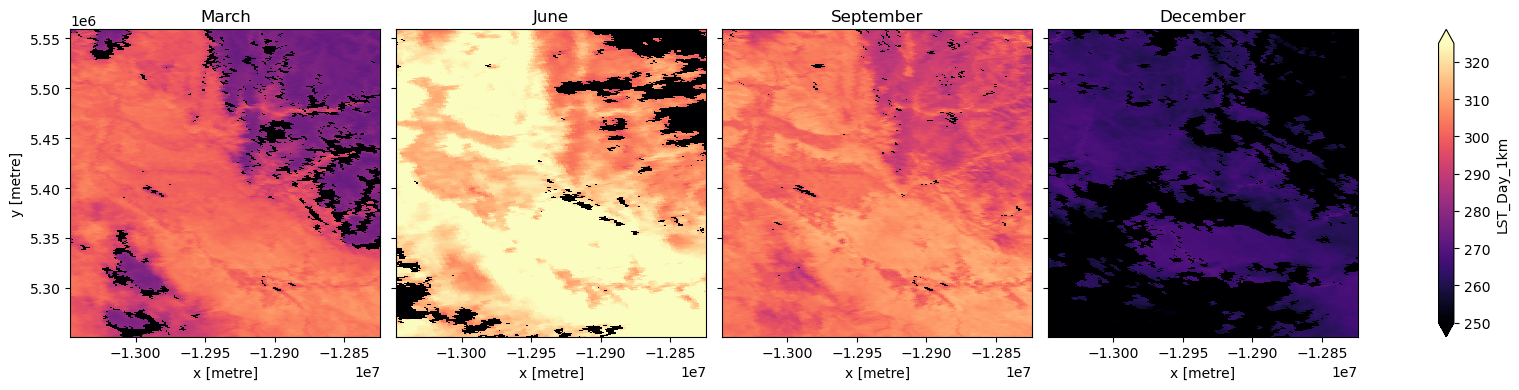

In [6]:
g = data.plot.imshow(cmap="magma", col="time", vmin=250, vmax=325, size=4)
datetimes = data.time.to_pandas().dt.strftime("%B")

for ax, datetime in zip(g.axes.flat, datetimes):
    ax.set_title(datetime)

### Change detection

Now let's see how the temperature changes between seasons.

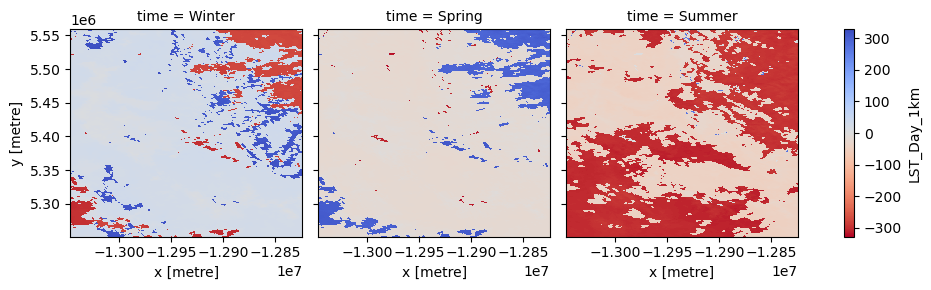

In [7]:
change = data.diff(dim="time").assign_coords(time=["Winter", "Spring", "Summer"])
change.plot.imshow(cmap="coolwarm_r", col="time");

### User guides

- MOD11: https://lpdaac.usgs.gov/documents/715/MOD11_User_Guide_V61.pdf
- MOD21: https://lpdaac.usgs.gov/documents/1398/MOD21_User_Guide_V61.pdf
